Found 311 images belonging to 2 classes.
Found 77 images belonging to 2 classes.
Classi: ['Test', 'Train']


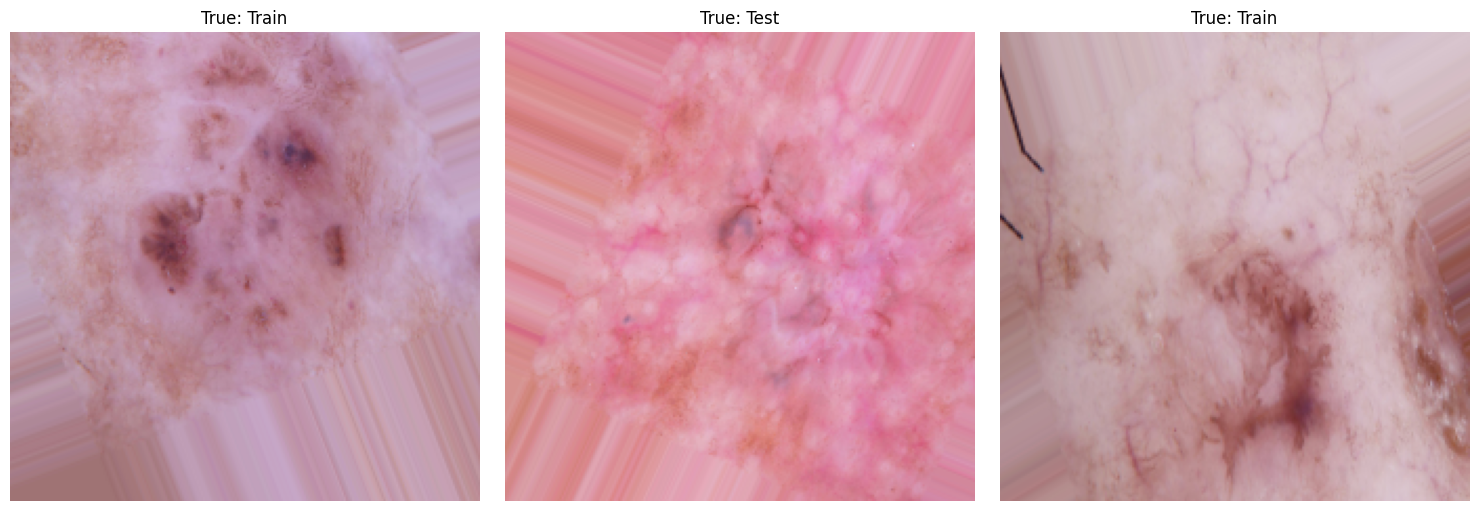

/opt/anaconda3/envs/ComputerVision/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Modello caricato da resnet50_skin_cancer.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 906ms/step
Classification Report:
              precision    recall  f1-score   support

        Test       0.00      0.00      0.00        23
       Train       0.70      1.00      0.82        54

    accuracy                           0.70        77
   macro avg       0.35      0.50      0.41        77
weighted avg       0.49      0.70      0.58        77



/opt/anaconda3/envs/ComputerVision/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ComputerVision/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ComputerVision/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

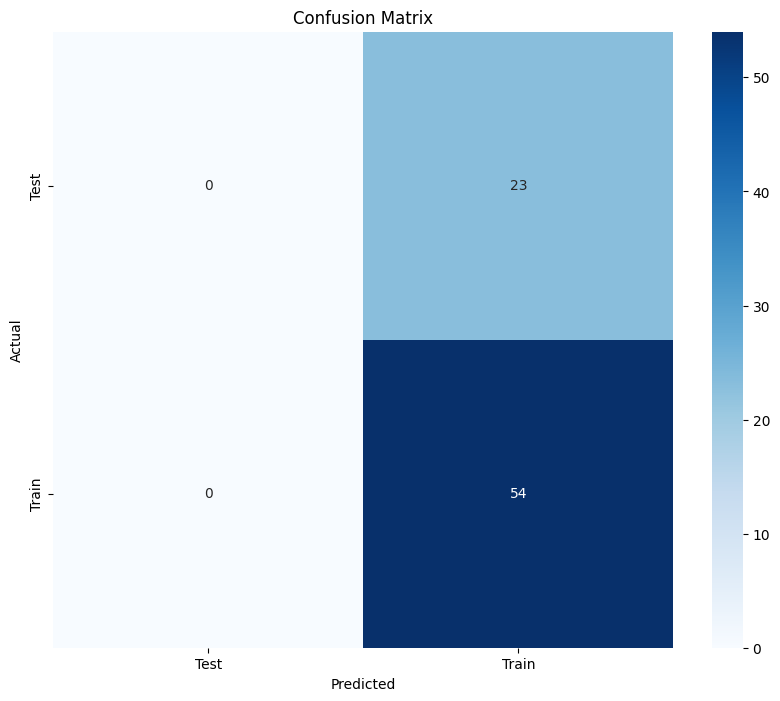

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


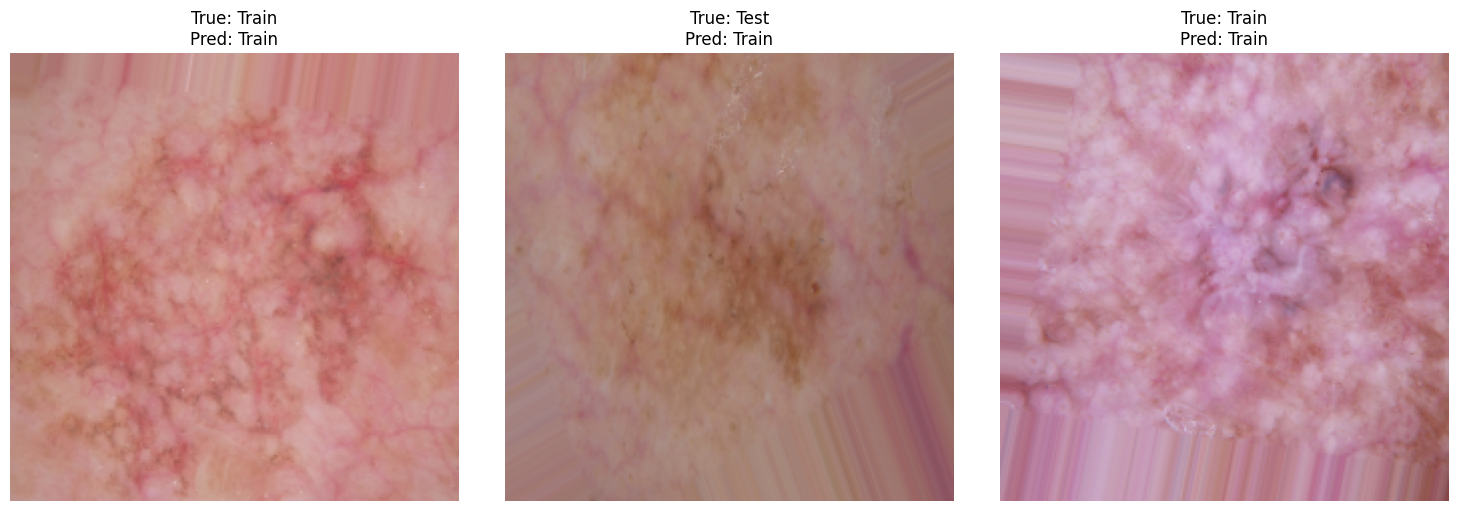

In [5]:
# Importazioni
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from skimage import exposure

# Percorso del dataset
BASE_DIR = "/Users/giulia/Documents/GitHub/CV_Project_IDM/ISIC_dataset"
MODEL_PATH = "resnet50_skin_cancer.h5"  # Percorso del modello salvato

# 1. Preprocessing e Augmentazione dei dati
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizzazione dell'immagine
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,  # Aggiunto per distorcere l'immagine
    zoom_range=0.2,  # Aggiunto per simulare variazioni di zoom
    horizontal_flip=True,
    fill_mode='nearest',  # Riempimento dei pixel vuoti
    validation_split=0.2  # 80% training, 20% validation
)

# Set di training
train_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Set di testing
validation_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Ottenere i nomi delle classi
class_names = list(train_generator.class_indices.keys())
print("Classi:", class_names)

# 2. Visualizzazione delle immagini originali (senza manipolazione) subito dopo il caricamento del dataset
def display_original_images(generator, class_names):
    # Prendere un batch di immagini originali
    images, labels = next(generator)

    # Modificato per visualizzare solo 3 immagini in una riga
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 riga, 3 colonne
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])  # Mostra l'immagine originale
        true_label = class_names[np.argmax(labels[i])]  # Etichetta vera
        ax.set_title(f"True: {true_label}")
        ax.axis('off')  # Nasconde gli assi
    plt.tight_layout()
    plt.show()

# Visualizzare 3 immagini originali dal validation set subito dopo il caricamento
display_original_images(validation_generator, class_names)

# 3. Controlla se il modello è già salvato
if os.path.exists(MODEL_PATH):
    # Carica il modello salvato
    model = load_model(MODEL_PATH)
    print(f"Modello caricato da {MODEL_PATH}")
else:
    # Caricamento del modello ResNet50 pre-addestrato
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Congelare i layer pre-addestrati
    for layer in base_model.layers:
        layer.trainable = False

    # Aggiungere i layer personalizzati
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(class_names), activation='softmax')(x)

    # Creare il modello finale
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compilare il modello
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # 4. Addestramento del modello base
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        verbose=1
    )

    # Visualizzazione dell'andamento della loss e dell'accuratezza
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during training')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy during training')
    plt.legend()

    plt.show()
    
# 5. Fine-tuning del modello
# Sbloccare alcuni layer della ResNet50
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    # Ricompilare con un learning rate più basso
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    # Continuare l'addestramento
    history_finetune = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=5,
        verbose=1
    )

# Salvataggio del modello
    model.save(MODEL_PATH)
    print(f"Modello salvato come {MODEL_PATH}")

# 6. Valutazione del modello
# Predizioni sul validation set
y_true = validation_generator.classes
y_pred = np.argmax(model.predict(validation_generator), axis=-1)
# Report di classificazione
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matrice di confusione
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 7. Visualizzazione delle predizioni
def display_predictions(generator, model, class_names):
    # Prendere un batch di immagini
    images, labels = next(generator)
    predictions = np.argmax(model.predict(images), axis=-1)

    # Modificato per visualizzare solo 3 immagini in una riga
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 riga, 3 colonne
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])  # Mostra l'immagine
        true_label = class_names[np.argmax(labels[i])]  # Etichetta vera
        pred_label = class_names[predictions[i]]  # Etichetta predetta
        ax.set_title(f"True: {true_label}\nPred: {pred_label}")
        ax.axis('off')  # Nasconde gli assi
    plt.tight_layout()
    plt.show()

# Visualizzare 3 predizioni dal validation set
display_predictions(validation_generator, model, class_names)